# ReelSense: Explainable Movie Recommender System
**Dataset:** MovieLens Latest Small (ml-latest-small)  
**Goal:** Personalized, explainable Top-K recommendations with diversity optimization.

This notebook implements:
- Data loading + preprocessing (time-based split: leave-last-N per user)
- EDA (plots + insights)
- Recommendation models:
  - Popularity baseline
  - User-User Collaborative Filtering
  - Item-Item Collaborative Filtering
  - Matrix Factorization (SVD via Surprise)
  - Hybrid (CF + content from genres + tags)
- Explainability layer (genre overlap + tag overlap + neighbor-based reasoning)
- Ranking + diversity metrics


In [3]:
#importing all libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10,5)
sns.set_style("whitegrid")


**Loading all datasets**

In [4]:
ratings = pd.read_csv("ratings.csv")
movies  = pd.read_csv("movies.csv")
tags    = pd.read_csv("tags.csv")
links   = pd.read_csv("links.csv")

print("Ratings shape:", ratings.shape)
print("Movies shape :", movies.shape)
print("Tags shape   :", tags.shape)
print("Links shape  :", links.shape)

ratings.head()


Ratings shape: (100836, 4)
Movies shape : (9742, 3)
Tags shape   : (3683, 4)
Links shape  : (9742, 3)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**Data Preprocessing**

In [ ]:

# Converting timestamps
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
tags["timestamp"] = pd.to_datetime(tags["timestamp"], unit="s")

# Cleaning genres
movies["genres"] = movies["genres"].fillna("(no genres listed)")
movies["genre_list"] = movies["genres"].apply(lambda x: x.split("|"))

# Cleaning tags
tags["tag"] = tags["tag"].astype(str).str.lower().str.strip()
tags["tag"] = tags["tag"].str.replace(r"[^a-z0-9\s]", "", regex=True)

# Aggregating tags per movie
movie_tags = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()
movie_tags.columns = ["movieId", "all_tags"]

movies = movies.merge(movie_tags, on="movieId", how="left")
movies["all_tags"] = movies["all_tags"].fillna("")

movies.head()


,movieId,title,genres,genre_list,all_tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",fantasy magic board game robin williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],pregnancy remake


**Time based train test split**

In [6]:

def leave_last_n_split(ratings_df, n=2):
    ratings_df = ratings_df.sort_values(["userId", "timestamp"])
    train_list = []
    test_list = []

    for user, group in ratings_df.groupby("userId"):
        if len(group) <= n:
            train_list.append(group)
        else:
            train_list.append(group.iloc[:-n])
            test_list.append(group.iloc[-n:])

    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)

    return train_df, test_df

train_ratings, test_ratings = leave_last_n_split(ratings, n=2)

print("Train size:", train_ratings.shape)
print("Test size :", test_ratings.shape)

train_ratings.head()


Train size: (99616, 4)
Test size : (1220, 4)


,userId,movieId,rating,timestamp
0,1,804,4.0,2000-07-30 18:08:19
1,1,1210,5.0,2000-07-30 18:08:19
2,1,2018,5.0,2000-07-30 18:08:43
3,1,2628,4.0,2000-07-30 18:08:43
4,1,2826,4.0,2000-07-30 18:08:43


**EDA and Data Visualization**

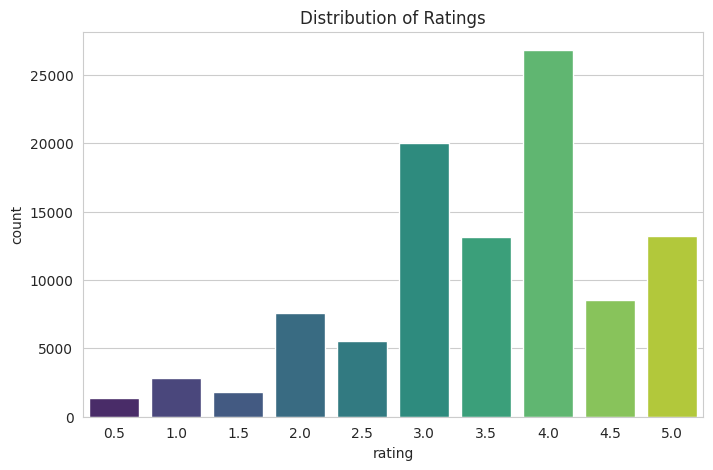

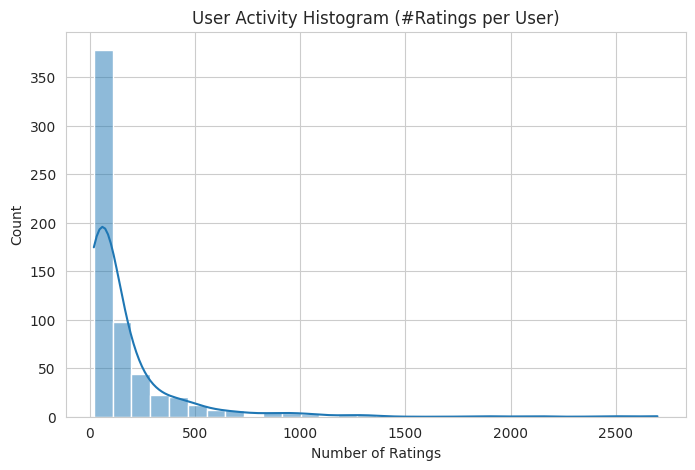

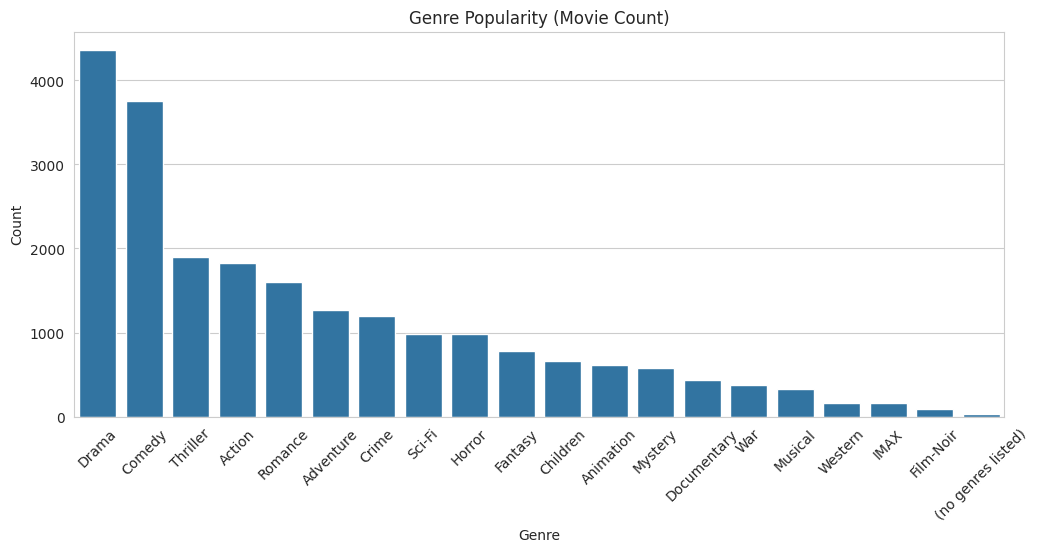

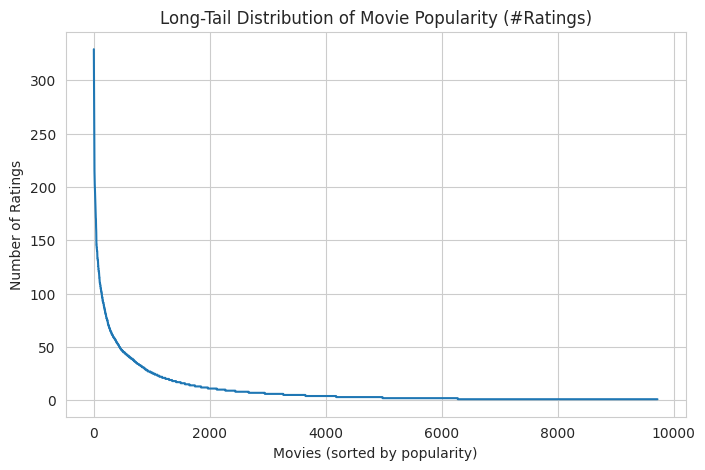

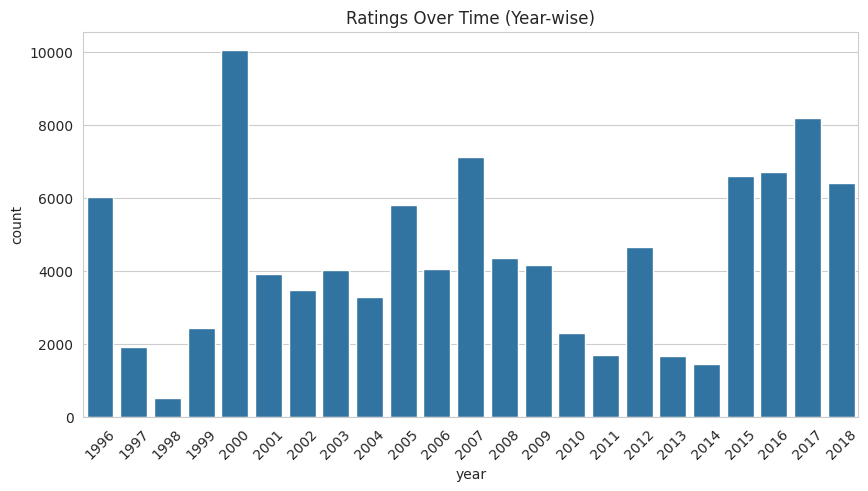

In [7]:
# Rating distribution
plt.figure(figsize=(8,5))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of Ratings")
plt.show()

# User activity histogram
user_activity = ratings.groupby("userId")["movieId"].count()
plt.figure(figsize=(8,5))
sns.histplot(user_activity, bins=30, kde=True)
plt.title("User Activity Histogram (#Ratings per User)")
plt.xlabel("Number of Ratings")
plt.show()

# Genre popularity (count of movies)
genre_counts = Counter([g for genres in movies["genre_list"] for g in genres])
genre_df = pd.DataFrame(genre_counts.items(), columns=["Genre", "Count"]).sort_values("Count", ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x="Genre", y="Count", data=genre_df)
plt.xticks(rotation=45)
plt.title("Genre Popularity (Movie Count)")
plt.show()

# Long-tail analysis: movie rating counts
movie_popularity = ratings.groupby("movieId")["rating"].count().sort_values(ascending=False)
plt.figure(figsize=(8,5))
plt.plot(movie_popularity.values)
plt.title("Long-Tail Distribution of Movie Popularity (#Ratings)")
plt.xlabel("Movies (sorted by popularity)")
plt.ylabel("Number of Ratings")
plt.show()

# Rating trend over time
ratings_by_year = ratings.copy()
ratings_by_year["year"] = ratings_by_year["timestamp"].dt.year
plt.figure(figsize=(10,5))
sns.countplot(x="year", data=ratings_by_year, order=sorted(ratings_by_year["year"].unique()))
plt.xticks(rotation=45)
plt.title("Ratings Over Time (Year-wise)")
plt.show()


**Popularity Baseline Model**

In [8]:
movie_stats = train_ratings.groupby("movieId").agg(
    avg_rating=("rating", "mean"),
    rating_count=("rating", "count")
).reset_index()

# Weighted rating (IMDB style)
C = movie_stats["avg_rating"].mean()
m = movie_stats["rating_count"].quantile(0.90)

movie_stats["weighted_score"] = (
    (movie_stats["rating_count"] / (movie_stats["rating_count"] + m)) * movie_stats["avg_rating"]
    + (m / (movie_stats["rating_count"] + m)) * C
)

pop_top = movie_stats.sort_values("weighted_score", ascending=False).head(10)
pop_top = pop_top.merge(movies[["movieId", "title", "genres"]], on="movieId")

pop_top


,movieId,avg_rating,rating_count,weighted_score,title,genres
0,318,4.431310,313,4.341465,"Shawshank Redemption, The (1994)",Crime|Drama
1,2959,4.272936,218,4.164987,Fight Club (1999),Action|Crime|Drama|Thriller
2,858,4.281915,188,4.157742,"Godfather, The (1972)",Crime|Drama
3,260,4.228000,250,4.136800,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,296,4.192434,304,4.118960,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
5,527,4.221963,214,4.117736,Schindler's List (1993),Drama|War
6,50,4.224747,198,4.112753,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
7,2571,4.189531,277,4.109758,"Matrix, The (1999)",Action|Sci-Fi|Thriller
8,1196,4.214286,210,4.109139,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
9,356,4.160000,325,4.093324,Forrest Gump (1994),Comedy|Drama|Romance|War


**User-Item Interaction Matrix**

In [9]:
user_item_matrix = train_ratings.pivot_table(index="userId", columns="movieId", values="rating").fillna(0)

print("User-Item matrix shape:", user_item_matrix.shape)

# Cosine similarity between users
user_sim = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

user_sim_df.iloc[:5,:5]


User-Item matrix shape: (610, 9681)


userId,1,2,3,4,5
userId,,,,,
1,1.000000,0.028113,0.059968,0.196093,0.132210
2,0.028113,1.000000,0.000000,0.003846,0.017413
3,0.059968,0.000000,1.000000,0.002265,0.005127
4,0.196093,0.003846,0.002265,1.000000,0.131999
5,0.132210,0.017413,0.005127,0.131999,1.000000


**User-User Collaborative Filtering Recommender**

In [10]:
def recommend_user_user(user_id, k=10, top_neighbors=10):
    if user_id not in user_item_matrix.index:
        return []

    sim_scores = user_sim_df[user_id].sort_values(ascending=False)[1:top_neighbors+1]
    neighbor_ids = sim_scores.index

    weighted_ratings = np.zeros(user_item_matrix.shape[1])
    sim_sum = sim_scores.sum()

    for neighbor in neighbor_ids:
        weighted_ratings += sim_scores[neighbor] * user_item_matrix.loc[neighbor].values

    if sim_sum > 0:
        weighted_ratings /= sim_sum

    scores = pd.Series(weighted_ratings, index=user_item_matrix.columns)

    # Remove already rated movies
    already_rated = train_ratings[train_ratings["userId"] == user_id]["movieId"].tolist()
    scores = scores.drop(labels=already_rated, errors="ignore")

    return scores.sort_values(ascending=False).head(k)

# Example
recommend_user_user(1, k=10)


,0
movieId,
589,4.195745
1200,4.123635
1374,3.945929
1653,3.921252
1036,3.902866
858,3.890098
1610,3.860532
2791,3.827691
2762,3.780066


**Item-Item Collaborative Filtering**

In [ ]:
item_user_matrix = user_item_matrix.T  # movies x users
item_sim = cosine_similarity(item_user_matrix)
item_sim_df = pd.DataFrame(item_sim, index=item_user_matrix.index, columns=item_user_matrix.index)

def recommend_item_item(user_id, k=10):
    if user_id not in user_item_matrix.index:
        return []

    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index.tolist()

    scores = defaultdict(float)

    for movie in rated_movies:
        similar_movies = item_sim_df[movie].sort_values(ascending=False)[1:51]
        for sim_movie, sim_score in similar_movies.items():
            if sim_movie not in rated_movies:
                scores[sim_movie] += sim_score * user_ratings[movie]

    scores = pd.Series(scores).sort_values(ascending=False).head(k)
    return scores

recommend_item_item(1, k=10)


**Matrix Factorization (SVD via Surprise)**

In [3]:
!pip install numpy==1.26.4
!pip install scikit-surprise --upgrade --no-deps

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(
    train_ratings[["userId", "movieId", "rating"]],
    reader
)

trainset = data.build_full_trainset()

svd_model = SVD(
    n_factors=50,
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02
)
svd_model.fit(trainset)

testset = [
    (row.userId, row.movieId, row.rating)
    for row in test_ratings.itertuples()
]

predictions = svd_model.test(testset)

rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

print("RMSE:", rmse)
print("MAE :", mae)


RMSE: 0.9268459954236585
MAE : 0.7156861594194929


**Content Features (Genres + Tags) using TF-IDF**

In [13]:
movies["content_text"] = movies["genres"].str.replace("|", " ", regex=False) + " " + movies["all_tags"]

tfidf = TfidfVectorizer(stop_words="english")
content_matrix = tfidf.fit_transform(movies["content_text"])

content_sim = cosine_similarity(content_matrix)

content_sim_df = pd.DataFrame(content_sim, index=movies["movieId"], columns=movies["movieId"])

def recommend_content(movie_id, k=10):
    if movie_id not in content_sim_df.index:
        return []

    sims = content_sim_df[movie_id].sort_values(ascending=False)[1:k+1]
    return sims

# Example content-based recommendations for movieId=1
recommend_content(1, k=10)


,1
movieId,
2355,0.862225
3114,0.644038
122918,0.367645
45074,0.357912
136016,0.357912
4886,0.357912
65577,0.357912
53121,0.357912
91355,0.357912


**Hybrid Recommendation (CF + Content Similarity Blend)**

In [15]:
def hybrid_recommend(user_id, k=10, alpha=0.7):
    # alpha = weight for CF, (1-alpha) = weight for content

    cf_scores = recommend_item_item(user_id, k=50)
    if len(cf_scores) == 0:
        return []

    # For content, taking movies user liked (rating >= 3.5)
    liked = train_ratings[(train_ratings["userId"] == user_id) & (train_ratings["rating"] >= 3.5)]["movieId"].tolist()

    content_scores = defaultdict(float)
    for m in liked:
        if m in content_sim_df.index:
            sims = content_sim_df[m].sort_values(ascending=False)[1:51]
            for sim_movie, sim_score in sims.items():
                content_scores[sim_movie] += sim_score

    content_scores = pd.Series(content_scores)

    # Normalizing the scores
    if len(content_scores) > 0:
        content_scores = (content_scores - content_scores.min()) / (content_scores.max() - content_scores.min() + 1e-9)
    if len(cf_scores) > 0:
        cf_scores = (cf_scores - cf_scores.min()) / (cf_scores.max() - cf_scores.min() + 1e-9)

    # Combining scores
    all_movies = set(cf_scores.index).union(set(content_scores.index))
    final_scores = {}

    for m in all_movies:
        final_scores[m] = alpha * cf_scores.get(m, 0) + (1-alpha) * content_scores.get(m, 0)

    final_scores = pd.Series(final_scores).sort_values(ascending=False)

    # Remove already rated movies
    already_rated = train_ratings[train_ratings["userId"] == user_id]["movieId"].tolist()
    final_scores = final_scores.drop(labels=already_rated, errors="ignore")

    return final_scores.head(k)

hybrid_recommend(1, k=10)


,0
2918,0.704449
2762,0.495243
1527,0.476230
1036,0.475643
1200,0.384646
858,0.355238
589,0.322710
1968,0.317539
2683,0.313119
2087,0.300679


**Explainability Layer**

In [16]:

def explain_recommendation(user_id, rec_movie_id):
    user_history = train_ratings[train_ratings["userId"] == user_id].merge(
        movies[["movieId", "title", "genre_list", "all_tags"]],
        on="movieId"
    )

    rec_movie = movies[movies["movieId"] == rec_movie_id].iloc[0]
    rec_genres = set(rec_movie["genre_list"])
    rec_tags = set(rec_movie["all_tags"].split())

    # Find top similar movie in history (by genre+tag overlap)
    best_match = None
    best_score = -1

    for _, row in user_history.iterrows():
        g_overlap = len(rec_genres.intersection(set(row["genre_list"])))
        t_overlap = len(rec_tags.intersection(set(row["all_tags"].split())))
        score = g_overlap + t_overlap

        if score > best_score:
            best_score = score
            best_match = row

    if best_match is None:
        return f"Recommended because it matches your general taste."

    return (
        f"Recommended because you liked **{best_match['title']}**, and this movie shares "
        f"genres {list(rec_genres.intersection(set(best_match['genre_list'])))} "
        f"and similar tags like {list(rec_tags.intersection(set(best_match['all_tags'].split())))[:5]}."
    )

# Example
sample_recs = hybrid_recommend(1, k=5)
for movie_id in sample_recs.index:
    title = movies[movies["movieId"] == movie_id]["title"].values[0]
    print("🎬", title)
    print("➡️", explain_recommendation(1, movie_id))
    print()


🎬 Ferris Bueller's Day Off (1986)
➡️ Recommended because you liked **Billy Madison (1995)**, and this movie shares genres ['Comedy'] and similar tags like ['school'].

🎬 Sixth Sense, The (1999)
➡️ Recommended because you liked **Pulp Fiction (1994)**, and this movie shares genres ['Drama'] and similar tags like ['250', 'twist', 'top', 'willis', 'bruce'].

🎬 Fifth Element, The (1997)
➡️ Recommended because you liked **Star Wars: Episode VI - Return of the Jedi (1983)**, and this movie shares genres ['Action', 'Adventure', 'Sci-Fi'] and similar tags like [].

🎬 Die Hard (1988)
➡️ Recommended because you liked **Shaft (2000)**, and this movie shares genres ['Action', 'Thriller', 'Crime'] and similar tags like [].

🎬 Aliens (1986)
➡️ Recommended because you liked **Star Wars: Episode IV - A New Hope (1977)**, and this movie shares genres ['Action', 'Adventure', 'Sci-Fi'] and similar tags like ['space', 'scifi', 'action'].



**Evaluation Metrics: Precision@K, Recall@K, NDCG@K, MAP@K**

In [17]:
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    if len(relevant) == 0:
        return 0
    return len(set(recommended_k) & set(relevant)) / len(relevant)

def dcg_at_k(recommended, relevant, k):
    dcg = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1 / np.log2(i + 2)
    return dcg

def ndcg_at_k(recommended, relevant, k):
    dcg = dcg_at_k(recommended, relevant, k)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(relevant)))])
    return dcg / idcg if idcg > 0 else 0

def average_precision_at_k(recommended, relevant, k):
    hits = 0
    score = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant), k) if relevant else 0

def map_at_k(all_recommended, all_relevant, k):
    ap_scores = []
    for user_id in all_recommended.keys():
        ap_scores.append(average_precision_at_k(all_recommended[user_id], all_relevant[user_id], k))
    return np.mean(ap_scores)

# Building relevance set from test data (movies rated >= 3.5 in test set)
test_relevant = test_ratings[test_ratings["rating"] >= 3.5].groupby("userId")["movieId"].apply(list).to_dict()

# Generating recommendations for each user
K = 10
all_recommended = {}
all_relevant = {}

for user_id in test_relevant.keys():
    recs = hybrid_recommend(user_id, k=K)
    all_recommended[user_id] = list(recs.index)
    all_relevant[user_id] = test_relevant[user_id]

precisions = []
recalls = []
ndcgs = []
aps = []

for user_id in all_recommended.keys():
    recommended = all_recommended[user_id]
    relevant = all_relevant[user_id]
    precisions.append(precision_at_k(recommended, relevant, K))
    recalls.append(recall_at_k(recommended, relevant, K))
    ndcgs.append(ndcg_at_k(recommended, relevant, K))
    aps.append(average_precision_at_k(recommended, relevant, K))

print("Precision@10:", np.mean(precisions))
print("Recall@10   :", np.mean(recalls))
print("NDCG@10     :", np.mean(ndcgs))
print("MAP@10      :", np.mean(aps))


Precision@10: 0.0128
Recall@10   : 0.082
NDCG@10     : 0.04396188029888763
MAP@10      : 0.02767261904761905


**Diversity Metrics**

In [18]:
# Diversity Metrics

# Catalog Coverage
def catalog_coverage(all_recs, total_items):
    recommended_items = set()
    for user in all_recs:
        recommended_items.update(all_recs[user])
    return len(recommended_items) / total_items

# Intra-List Diversity (ILD) using content similarity
def intra_list_diversity(recommended_list):
    if len(recommended_list) < 2:
        return 0

    sims = []
    for i in range(len(recommended_list)):
        for j in range(i+1, len(recommended_list)):
            m1 = recommended_list[i]
            m2 = recommended_list[j]
            if m1 in content_sim_df.index and m2 in content_sim_df.index:
                sims.append(content_sim_df.loc[m1, m2])
    if len(sims) == 0:
        return 0
    return 1 - np.mean(sims)

# Popularity-Normalized Hits (novelty-like metric)
movie_pop = train_ratings.groupby("movieId")["rating"].count().to_dict()

def popularity_normalized_hits(recommended_list):
    score = 0
    for m in recommended_list:
        pop = movie_pop.get(m, 1)
        score += 1 / np.log2(pop + 2)
    return score / len(recommended_list)

total_items = movies["movieId"].nunique()

coverage = catalog_coverage(all_recommended, total_items)
ild_scores = [intra_list_diversity(all_recommended[u]) for u in all_recommended]
novelty_scores = [popularity_normalized_hits(all_recommended[u]) for u in all_recommended]

print("Catalog Coverage:", coverage)
print("Avg Intra-List Diversity:", np.mean(ild_scores))
print("Avg Popularity-Normalized Hits:", np.mean(novelty_scores))


Catalog Coverage: 0.05532744816259495
Avg Intra-List Diversity: 0.8890222629086004
Avg Popularity-Normalized Hits: 0.1566564836779958


**Reducing size of .pkl for deployment purpose**

In [19]:
item_similarity_reduced = {}

for movie_id in item_sim_df.columns:
    # Get similarity scores for the current movie, exclude itself
    similar_movies = item_sim_df[movie_id].sort_values(ascending=False)

    # Exclude the movie itself (similarity will be 1.0) and take top 100
    top_100_similar = similar_movies[similar_movies.index != movie_id].head(100)

    # Store as a list of (similar_movieId, similarity_score) tuples
    item_similarity_reduced[movie_id] = list(top_100_similar.items())

print(f"Processed similarity for {len(item_similarity_reduced)} movies.")
print(f"Example for movieId 1: {item_similarity_reduced.get(1)[:5]}")

Processed similarity for 9681 movies.
Example for movieId 1: [(780, 0.568417373165308), (480, 0.5683883263456562), (3114, 0.5668576318075443), (260, 0.5551426172921984), (356, 0.5510114436526559)]


In [20]:
content_similarity_reduced = {}

for movie_id in content_sim_df.columns:
    # Get similarity scores for the current movie, exclude itself
    similar_movies = content_sim_df[movie_id].sort_values(ascending=False)

    # Exclude the movie itself (similarity will be 1.0) and take top 100
    top_100_similar = similar_movies[similar_movies.index != movie_id].head(100)

    # Store as a list of (similar_movieId, similarity_score) tuples
    content_similarity_reduced[movie_id] = list(top_100_similar.items())

print(f"Processed content similarity for {len(content_similarity_reduced)} movies.")
print(f"Example for movieId 1: {content_similarity_reduced.get(1)[:5]}")

Processed content similarity for 9742 movies.
Example for movieId 1: [(2355, 0.8622245217448579), (3114, 0.6440378332144655), (122918, 0.3676451835031899), (45074, 0.35791173214523103), (136016, 0.35791173214523103)]


**For deployment**

In [26]:
import pickle

# 1️⃣ Movies metadata (titles, genres, tags)
with open("movies.pkl", "wb") as f:
    pickle.dump(movies, f)

# 2️⃣ Train ratings (user history for explanations & filtering)
with open("train_ratings.pkl", "wb") as f:
    pickle.dump(train_ratings, f)

# 3️⃣ User-Item interaction matrix
with open("user_item_matrix.pkl", "wb") as f:
    pickle.dump(user_item_matrix, f)

# 4️⃣ Item-Item Collaborative Filtering similarity (top-100 reduced)
with open("item_similarity_reduced.pkl", "wb") as f:
    pickle.dump(item_similarity_reduced, f)

# 5️⃣ Content-based similarity (genres + tags, top-100 reduced)
with open("content_similarity_reduced.pkl", "wb") as f:
    pickle.dump(content_similarity_reduced, f)

# 6️⃣ Trained SVD model (Matrix Factorization)
with open("svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)

#  TF-IDF vectorizer (used for content features)
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

#  (Optional but recommended) Content TF-IDF matrix
with open("content_matrix.pkl", "wb") as f:
    pickle.dump(content_matrix, f)

print("✅ All .pkl files saved successfully!")


✅ All .pkl files saved successfully!
